# Terzo prototipo di modello ML: SVM

Liberie varie da installare

In [100]:
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install imblearn

Inclusione delle librerie utilizzate

In [101]:
from os.path import exists
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.kernel_approximation import RBFSampler, SkewedChi2Sampler, Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Variabili di gestione files, parametri del modello e della fase di training

In [102]:
# Path of the dataset in .pkl format, can be changed
PATH_DATASET = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset_output\complete_active_bankruptcy_big.pkl"

# True = Standardize data, can be changed
to_standardize = True

# True = Oversample/Undersample the least/most populated class (Bankruptcy), can be changed
avoid_imbalanced_training = True

# Oversample or Undersample, can be changed.
# It only affects the notebook if avoid_imbalanced_training is True
imbalanced_data_technique = "Oversample"

# True = Also use non financial indexes features like the legal form or the size of the company
additional_features = True

# A value between [0, 1], it represent the percentage of records not used during training time, can be changed
train_test_split_amount = 0.25

# Select a random state value in order to control the randomness effect, can be changed
rnd_state = 25

# Specify the number of cuncurrent jobs in order to speed up certain traning phases.
# Specify -1 in order to use all the job available, the default one is 1, can be changed
n_jobs = -1

# True = Export the current experiment inside the dataframe that collects all of them, can be changed
to_export = True

# Path of the dataset in .pkl format to store all the experiments, can be changed and if not present it will be created
OUTPUT_PATH = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\ML_models"

Controllo se esiste il dataset di output

In [103]:
# Only if we want to export
if to_export:
    if exists(OUTPUT_PATH + "/ML_model_experiments.pkl"):
        # If the dataset exists, read it
        output_dataset = pd.read_pickle(OUTPUT_PATH + "/ML_model_experiments.pkl")
        print("Dataset di output trovato")
    else:
        # Otherwise create it
        output_dataset = pd.DataFrame()
        print("Dataset di output non trovato, creo un nuovo dataset")

Dataset di output trovato


Lettura del dataset di input

In [104]:
dataset = pd.read_pickle(PATH_DATASET)
print("Il dataset da utilizzare ha", dataset.shape[0], "record e", dataset.shape[1], "colonne")

Il dataset da utilizzare ha 1568479 record e 22 colonne


Suddivisione del dataset in X e Y, dove X sono le features in ingresso (indicatori finanziari) e Y è la risposta in output (attivo/bancarotta)

In [105]:
X_features_names = ['PN/Totale Debiti',
                    'Deb. Prev + Trib/Attivo',
                    'Tempo medio riscossione (TMR)',
                    'Tempo medio di pagamento (TMP)',
                    'PFN/EBITDA',
                    'PFN/PN',
                    'Gearing',
                    'ROS',
                    'Working capital/net sales',
                    'Cash/Current Liabilities',
                    'Accounts receivable/inventory',
                    'EBIT/interest expenses',
                    'Att.Br/Attivo',
                    'Ricavi/Attivo',
                    'EBITDA/Totale Debiti']

if additional_features:
    X_features_names.append('Legal Form')
    #X_features_names.append('Company Size')

Y_feature_name = 'Legal Status'

X_dataset = dataset[X_features_names].copy()

if additional_features:
    # One hot encoding
    X_dataset = X_dataset.join(pd.get_dummies(dataset['Legal Form']))
    X_dataset.drop('Legal Form', axis = 1, inplace=True)

    #X_dataset = X_dataset.join(pd.get_dummies(dataset['Company Size']))
    #X_dataset.drop('Company Size', axis = 1, inplace=True)

    # Save the new feature names
    X_features_names = X_dataset.columns.to_list()

Y_dataset = dataset[Y_feature_name].copy()

Stampo i primi record dei 2 nuovi dataset per chiarezza

In [106]:
X_dataset.head()

,PN/Totale Debiti,Deb. Prev + Trib/Attivo,Tempo medio riscossione (TMR),Tempo medio di pagamento (TMP),PFN/EBITDA,PFN/PN,Gearing,ROS,Working capital/net sales,Cash/Current Liabilities,Accounts receivable/inventory,EBIT/interest expenses,Att.Br/Attivo,Ricavi/Attivo,EBITDA/Totale Debiti,Altro,Società di capitali,Società di persone
0,0.062759,0.018469,132.395004,75.595004,4.934119,10.264500,0.911226,0.083199,0.775917,0.090424,1.128547,3.595384,0.894619,1.152983,0.130558,0,1,0
1,0.004904,0.000047,5.730942,2083.270723,-179.934494,174.011292,0.994286,-0.377653,79.832063,0.009702,0.000200,-5053.000000,0.997454,0.012494,-0.004743,0,1,0
2,18.662857,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.443113,0.688200,0.000000,0.000000,93.286842,1.000000,1.453066,12.703214,0,1,0
3,0.210145,0.012336,59.357925,80.109660,9.836861,3.533378,0.779414,0.071155,0.322540,0.004904,2.418841,1.184761,0.212252,0.658064,0.075484,0,1,0
4,0.674673,0.180218,191.973490,512.136986,-1.032501,-1.146575,7.822446,0.519637,1.106529,0.773563,0.000000,705.666667,0.886442,0.801101,0.749213,0,1,0


In [107]:
Y_dataset.head()

0    Active
1    Active
2    Active
3    Active
4    Active
Name: Legal Status, dtype: object

Codifico la variabile di risposta (Active/Bankruptcy) in (0/1)

In [108]:
Y_dataset.replace({"Active": 0, "Bankruptcy": 1}, inplace=True)
Y_dataset.head()

0    0
1    0
2    0
3    0
4    0
Name: Legal Status, dtype: int64

Controllo il numero di record per ciascuna classe

In [109]:
Y_dataset.value_counts()

0    1236429
1     332050
Name: Legal Status, dtype: int64

Uso la tecnica di random oversampling o undersampling per evitare un allenamento di un modello con classi sbilanciate

In [110]:
if avoid_imbalanced_training:
    # Oversample
    if imbalanced_data_technique == "Oversample":
        sm = SMOTE(random_state=rnd_state, n_jobs=n_jobs)
        X_dataset, Y_dataset = sm.fit_resample(X_dataset, Y_dataset)
    # Undersample
    elif imbalanced_data_technique == "Undersample":
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=rnd_state)
        X_dataset, Y_dataset = undersample.fit_resample(X_dataset, Y_dataset)
    else:
        print("Error: wrong variable value about imbalanced data")
Y_dataset.value_counts()

0    1236429
1    1236429
Name: Legal Status, dtype: int64

Standardizzo i dati contenuti in X

In [111]:
if to_standardize:
    scaler = StandardScaler()
    X_dataset = scaler.fit_transform(X_dataset)
    rbf_sampler = RBFSampler(random_state=rnd_state)
    X_dataset = rbf_sampler.fit_transform(X_dataset)

Divido i 2 dataset in train e test

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset,
                                                    Y_dataset,
                                                    stratify=Y_dataset,
                                                    test_size=train_test_split_amount,
                                                    random_state=rnd_state)

Creo primo prototipo di SVM e lo alleno sui dati di train

In [113]:
svc_classifier = SGDClassifier(loss='hinge', random_state=rnd_state)
rbf_feature = RBFSampler()
svc_classifier.fit(X_train, Y_train)

SGDClassifier(random_state=25)

Guardo come si comporta sui dati di test che il modello non ha mai visto

In [114]:
Y_predicted = svc_classifier.predict(X_test)
score = accuracy_score(Y_test, Y_predicted)

print("L'accuratezza è", score)

L'accuratezza è 0.6144723114126962


Matrice di confusione

[Text(0, 0.5, 'Active'), Text(0, 1.5, 'Bankruptcy')]

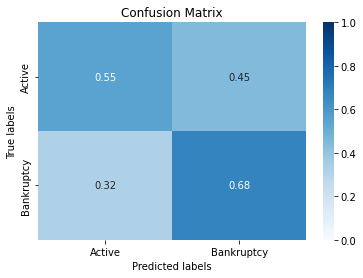

In [115]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_predicted)
conf_matrix = conf_matrix / conf_matrix.astype(np.float64).sum(axis=1)

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, vmin=0.0, vmax=1.0, fmt=".2f", cmap="Blues", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Active', 'Bankruptcy'])
ax.yaxis.set_ticklabels(['Active', 'Bankruptcy'])

In [ ]:
if to_export:
    if not avoid_imbalanced_training:
        imbalanced_data_technique = "N.A."

    # Compute metrics to be added to the dataset
    accuracy = accuracy_score(Y_test, Y_predicted)
    precision = precision_score(Y_test, Y_predicted)
    recall = recall_score(Y_test, Y_predicted)
    f1 = f1_score(Y_test, Y_predicted)

    # Create a new record
    new_record = pd.DataFrame({"Date": [date.today()],
                              "Model type": ["SGD Classifier"],
                              "Model parameters": [svc_classifier.get_params()],
                              "Data source": [PATH_DATASET.split("\\")[-1]],
                              "Features": [X_features_names],
                              "Standardized": [to_standardize],
                              "Imbalanced data corrections": [avoid_imbalanced_training],
                              "Imbalanced data technique": [imbalanced_data_technique],
                              "Number of active companies used": [Y_dataset.value_counts()[0]],
                              "Number of bankruptcy companies used": [Y_dataset.value_counts()[1]],
                              "Train/Test split": [train_test_split_amount],
                              "Random state": [rnd_state],
                              "Accuracy": [accuracy],
                              "Precision": [precision],
                              "Recall": [recall],
                              "F1-score": [f1],
                              "AUC": np.NaN})

    # Append the new record
    output_dataset = pd.concat([output_dataset, new_record], ignore_index=True, axis=0)

    # Export the dataset
    output_dataset.to_pickle(OUTPUT_PATH + "/ML_model_experiments.pkl")
    print("Esprimento aggiunto al dataset")